In [24]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [25]:
# Load data
df = pd.read_csv("oil_price.csv", parse_dates=["Date"], index_col="Date")
df = df.drop_duplicates()
df = df.asfreq('D')  # Ensure daily frequency
df = df.fillna(method='ffill')  # Forward fill missing values

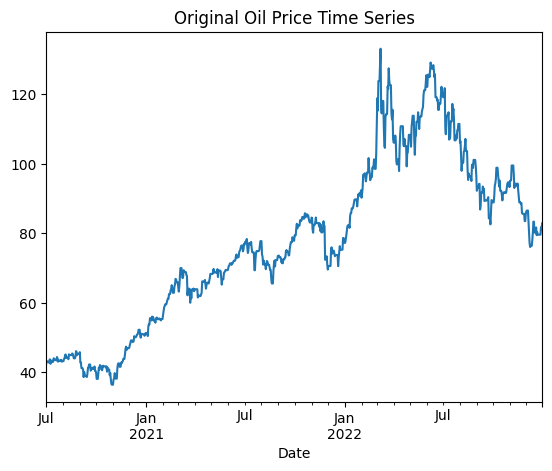

In [26]:
df['Price'].plot(title="Original Oil Price Time Series")
plt.show()


In [27]:
#since differencing is needed
series = df['Price']
differencing_count = 0
result = adfuller(series.dropna())
print(f"Differencing {differencing_count} times: ADF Statistic: {result[0]}, p-value: {result[1]}")

while result[1] > 0.05:
    series = series.diff().dropna()
    differencing_count += 1
    result = adfuller(series)
    print(f"Differencing {differencing_count} times: ADF Statistic: {result[0]}, p-value: {result[1]}")



Differencing 0 times: ADF Statistic: -1.4655649255837888, p-value: 0.5504719423943449
Differencing 1 times: ADF Statistic: -5.517177346651896, p-value: 1.913376107071688e-06


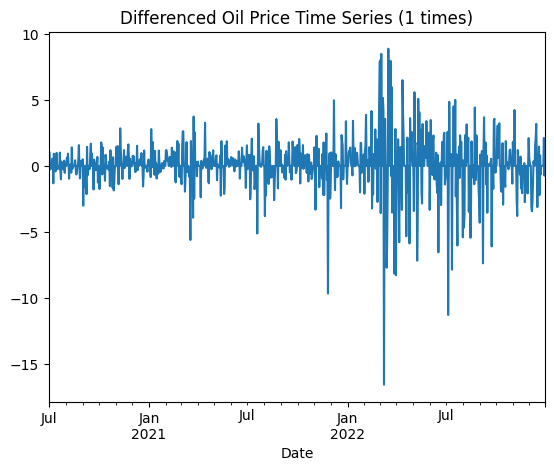

In [28]:
df[f'Price_diff_{differencing_count}'] = series

# Plot the differenced series
df[f'Price_diff_{differencing_count}'].plot(title=f"Differenced Oil Price Time Series ({differencing_count} times)")
plt.show()

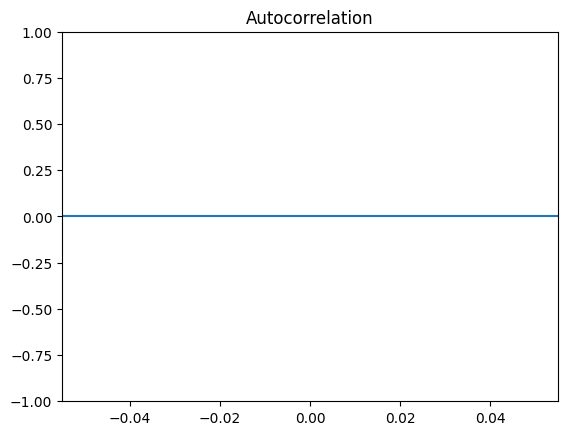

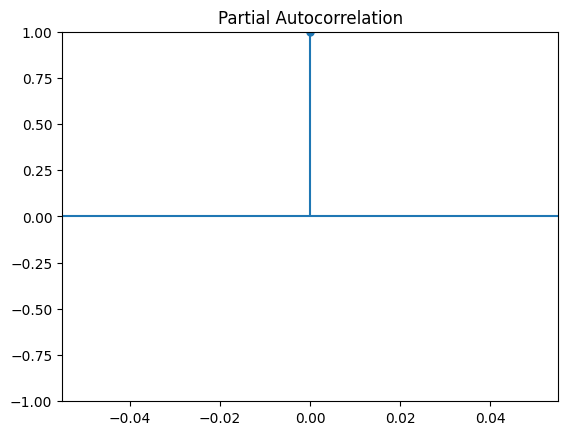

In [29]:
# Plot ACF and PACF
plot_acf(df[f'Price_diff_{differencing_count}'], lags=30)
plt.show()
plot_pacf(df[f'Price_diff_{differencing_count}'], lags=30)
plt.show()

In [30]:
# Grid search for ARIMA parameters
p = range(0, 8)
d = range(0, 2)
q = range(0,8)

In [31]:
best_aic = np.inf
best_order = None
best_model = None

In [32]:
# Forecast for 24 months
for order in product(p, d, q):
    try:
        model = ARIMA(df[f'Price_diff_{differencing_count}'], order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print("Best ARIMA order:", best_order)
print("Best AIC:", best_aic)

Best ARIMA order: (6, 0, 6)
Best AIC: 3725.730748897552


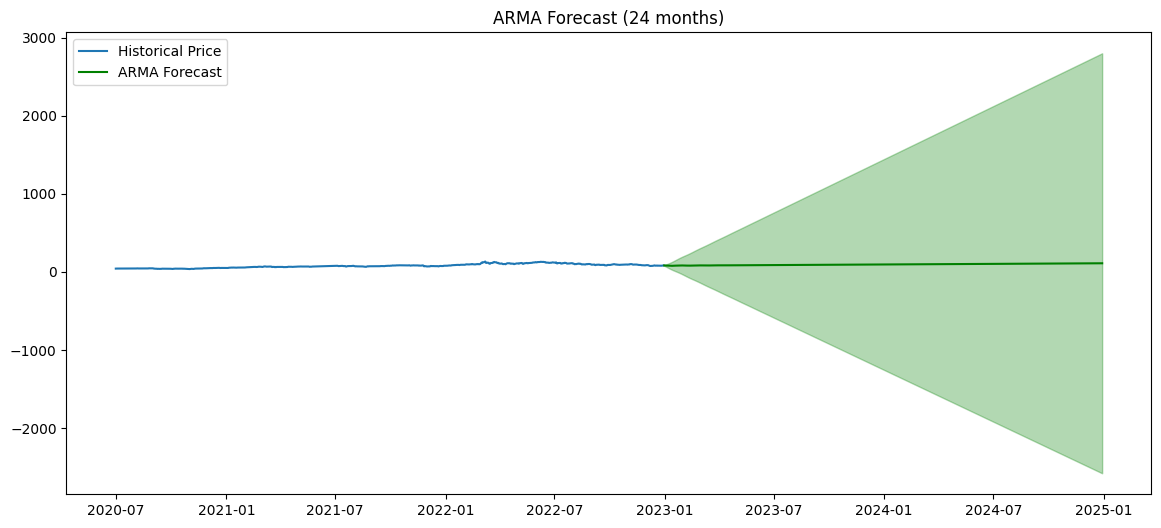

In [33]:
# %% Forecast from ARMA
forecast = best_model.get_forecast(steps=730)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Reconstruct forecasted price (cumulative sum of differenced forecast)
start_price = df['Price'].iloc[-1]
forecast_price = start_price + forecast_mean.cumsum()
forecast_upper = start_price + conf_int.iloc[:, 1].cumsum()
forecast_lower = start_price + conf_int.iloc[:, 0].cumsum()

# %% Plot ARMA forecast
plt.figure(figsize=(14, 6))
plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_price, label='ARMA Forecast', color='green')
plt.fill_between(forecast_price.index, forecast_lower, forecast_upper, color='green', alpha=0.3)
plt.title("ARMA Forecast (24 months)")
plt.legend()
plt.show()


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get in-sample predictions (historical fit)
arima_pred = best_model.predict(start=df.index[differencing_count], end=df.index[-1])
# Reconstruct the original price from differenced predictions
arima_pred_cumsum = arima_pred.cumsum() + df['Price'].iloc[differencing_count-1] if differencing_count > 0 else arima_pred
arima_pred_cumsum.index = df.index[differencing_count:]

# Align actual and predicted
actual = df['Price'].iloc[differencing_count:]
predicted = arima_pred_cumsum

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(actual, predicted))
arima_mae = mean_absolute_error(actual, predicted)
arima_mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"ARIMA RMSE on historical data: {arima_rmse:.2f}")
print(f"ARIMA MAE on historical data: {arima_mae:.2f}")
print(f"ARIMA MAPE on historical data: {arima_mape:.2f}%")

ARIMA RMSE on historical data: 24.72
ARIMA MAE on historical data: 19.01
ARIMA MAPE on historical data: 21.45%


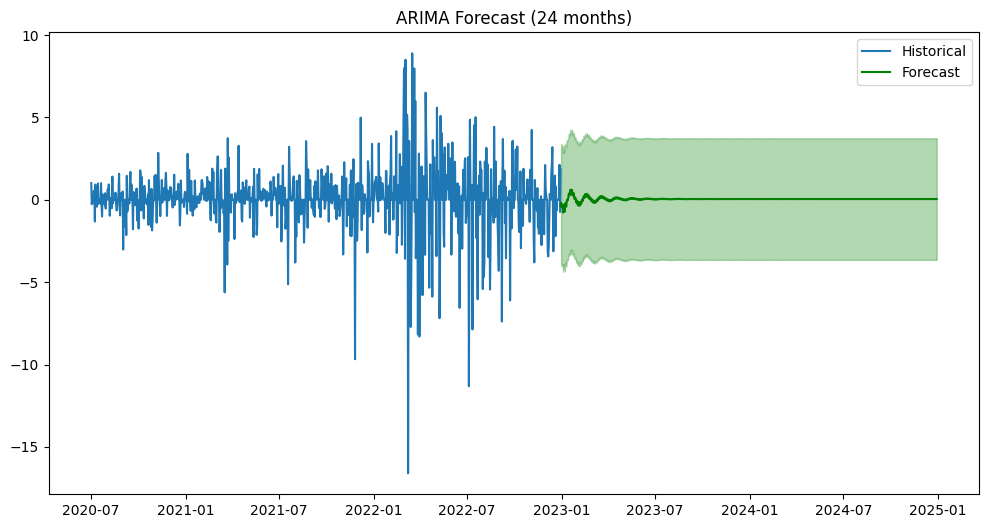

In [35]:
plt.figure(figsize=(12,6))
plt.plot(df[f'Price_diff_{differencing_count}'], label="Historical")
plt.plot(forecast_mean, label="Forecast", color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='green', alpha=0.3)
plt.title("ARIMA Forecast (24 months)")
plt.legend()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3s8rwcm/1lhzgt03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa3s8rwcm/jwohn1x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90538', 'data', 'file=/tmp/tmpa3s8rwcm/1lhzgt03.json', 'init=/tmp/tmpa3s8rwcm/jwohn1x9.json', 'output', 'file=/tmp/tmpa3s8rwcm/prophet_model50e6uv1f/prophet_model-20250701014941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:49:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


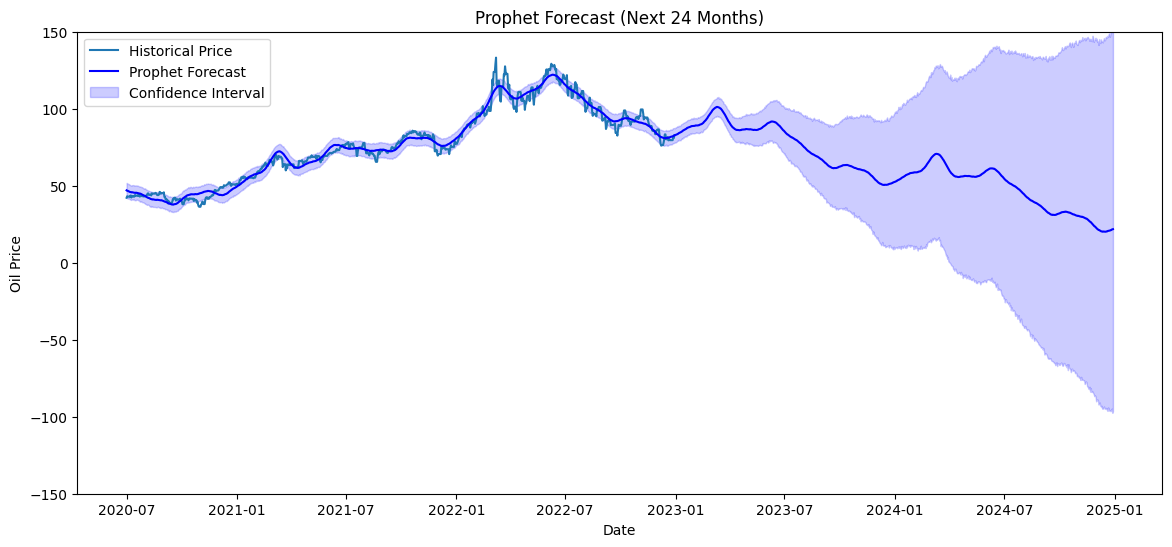

Prophet MAE on historical data: 2.92
Prophet MAPE on historical data: 4.16%
Prophet RMSE on historical data: 3.70


In [36]:



from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Prepare data for Prophet
df_prophet = df.reset_index()[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})

# Initialize and fit Prophet model
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(df_prophet)

# Create future dataframe for 730 days
future = model_prophet.make_future_dataframe(periods=730, freq='D')
forecast = model_prophet.predict(future)

# Plot Prophet forecast with confidence intervals
plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Historical Price')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
plt.title("Prophet Forecast (Next 24 Months)")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.legend()
plt.ylim(-150,150)
plt.show()

# Calculate RMSE on historical period
# Merge actual and predicted for the historical period only
merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds', how='left')
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(merged['y'], merged['yhat'])
print(f"Prophet MAE on historical data: {mae:.2f}")

# Calculate MAPE (avoid division by zero)
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100
print(f"Prophet MAPE on historical data: {mape:.2f}%")
print(f"Prophet RMSE on historical data: {rmse:.2f}")

In [37]:
import yfinance as yf

# Download only the needed data
data = yf.download('CL=F', start='2020-01-01', end='2024-12-30')[['Close']]

# Reset index to make 'Date' a column instead of index
data = data.reset_index()

# Rename columns for clarity (optional)
data = data.rename(columns={'Date': 'date', 'Close': 'price'})

print(data.head())

[*********************100%***********************]  1 of 1 completed

Price        date      price
Ticker                  CL=F
0      2020-01-02  61.180000
1      2020-01-03  63.049999
2      2020-01-06  63.270000
3      2020-01-07  62.700001
4      2020-01-08  59.610001


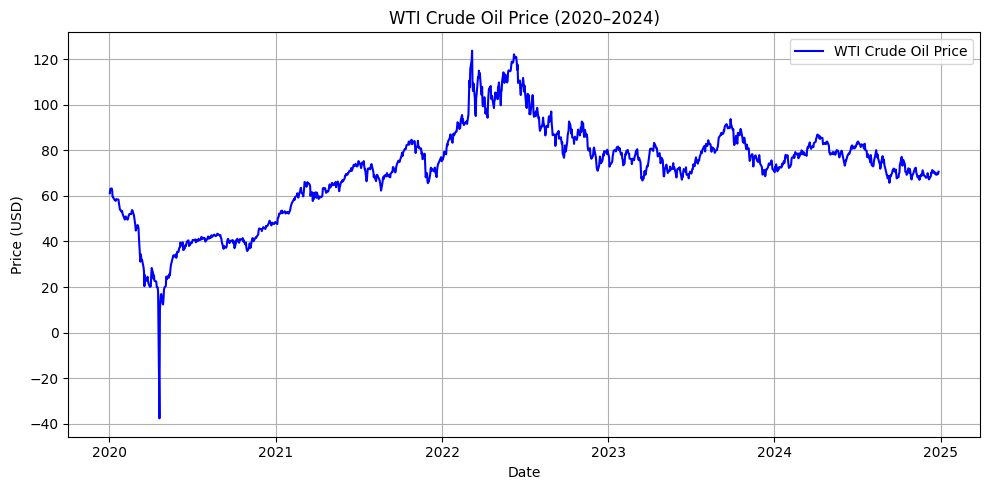

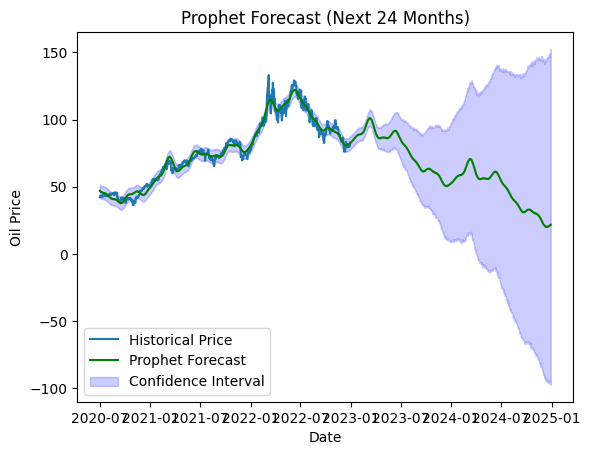

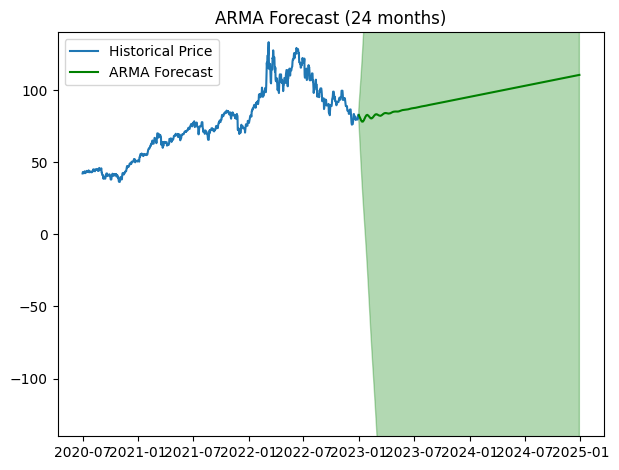

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Optional: adjust figure size
plt.plot(data['date'], data['price'], label='WTI Crude Oil Price', color='blue')
# Label the plot
plt.title('WTI Crude Oil Price (2020–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjusts plot to fit labels nicely
plt.show()

plt.plot(df_prophet['ds'], df_prophet['y'], label='Historical Price')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
plt.title("Prophet Forecast (Next 24 Months)")
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.legend()
plt.show()

plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_price, label='ARMA Forecast', color='green')
plt.fill_between(forecast_price.index, forecast_lower, forecast_upper, color='green', alpha=0.3)
plt.title("ARMA Forecast (24 months)")
plt.legend()
plt.tight_layout()
plt.ylim(-140, 140)
plt.show()

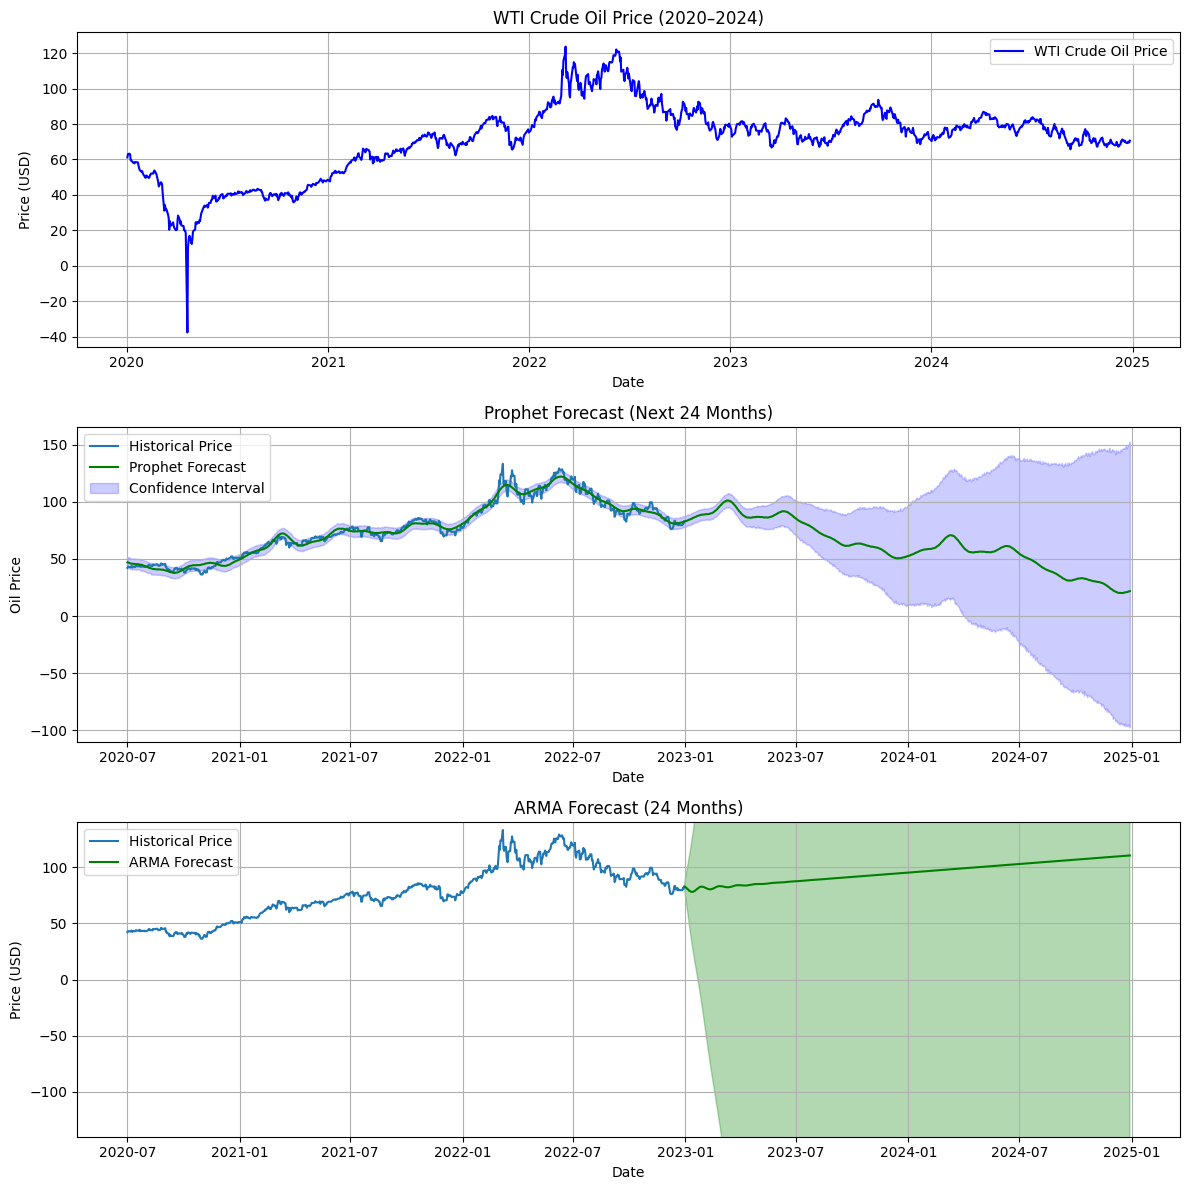

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column

# --- Plot 1: Historical WTI Crude Oil Price ---
axs[0].plot(data['date'], data['price'], label='WTI Crude Oil Price', color='blue')
axs[0].set_title('WTI Crude Oil Price (2020–2024)')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].grid(True)
axs[0].legend()

# --- Plot 2: Prophet Forecast ---
axs[1].plot(df_prophet['ds'], df_prophet['y'], label='Historical Price')
axs[1].plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='green')
axs[1].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
axs[1].set_title("Prophet Forecast (Next 24 Months)")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Oil Price")
axs[1].legend()
axs[1].grid(True)

# --- Plot 3: ARMA Forecast ---
axs[2].plot(df['Price'], label='Historical Price')
axs[2].plot(forecast_price, label='ARMA Forecast', color='green')
axs[2].fill_between(forecast_price.index, forecast_lower, forecast_upper, color='green', alpha=0.3)
axs[2].set_title("ARMA Forecast (24 Months)")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Price (USD)")
axs[2].legend()
axs[2].grid(True)
axs[2].set_ylim(-140, 140)

# --- Layout ---
plt.tight_layout()
plt.show()


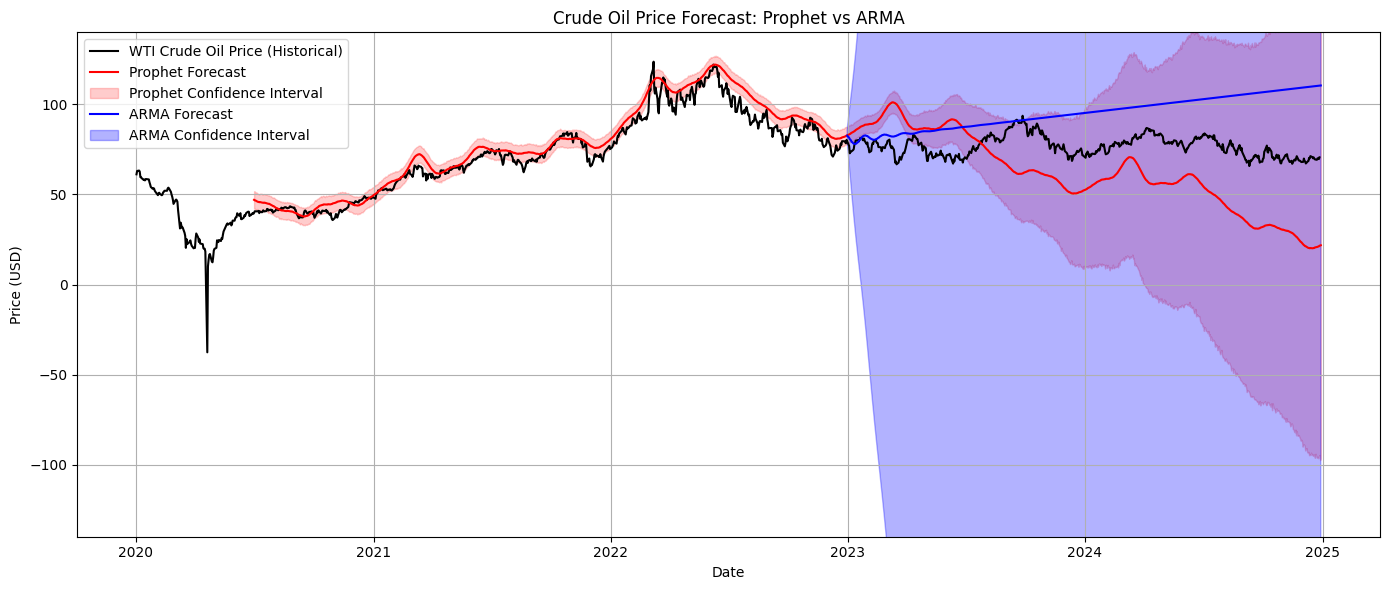

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# --- Historical Price (from original data) ---
plt.plot(data['date'], data['price'], label='WTI Crude Oil Price (Historical)', color='black')

# --- Prophet Forecast ---
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='red', alpha=0.2, label='Prophet Confidence Interval')

# --- ARMA Forecast ---
plt.plot(forecast_price.index, forecast_price, label='ARMA Forecast', color='blue')
plt.fill_between(forecast_price.index, forecast_lower, forecast_upper,
                 color='blue', alpha=0.3, label='ARMA Confidence Interval')

# --- Labels, legend, and layout ---
plt.title("Crude Oil Price Forecast: Prophet vs ARMA")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.ylim(-140, 140)
plt.tight_layout()

plt.show()


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1920.39
Distribution:                  Normal   AIC:                           3848.77
Method:            Maximum Likelihood   BIC:                           3868.04
                                        No. Observations:                  912
Date:                Tue, Jul 01 2025   Df Residuals:                      911
Time:                        01:49:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1274  6.382e-02      1.997  4.584e-02 [2.353e-0

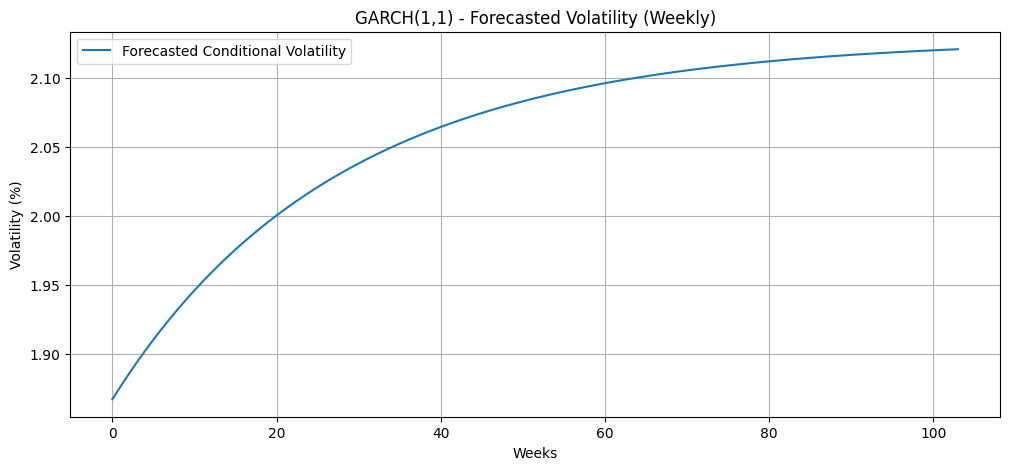

Model       RMSE    MAE    MAPE
----------  ------  -----  ------
ARMA        24.5    18.8   21.22%
Prophet     3.77    2.98   4.26%
ARMA-GARCH  N/A     N/A    N/A


In [41]:
returns = 100 * df['Price'].pct_change().dropna()

# Fit GARCH(1,1) model
from arch import arch_model
garch = arch_model(returns, vol='GARCH', p=1, q=1)
garch_result = garch.fit(disp='off')

print(garch_result.summary())

# Forecasting volatility
forecast_horizon = 104
garch_forecasts = garch_result.forecast(horizon=forecast_horizon)
cond_vol = np.sqrt(garch_forecasts.variance.values[-1, :])

# Plot conditional volatility forecast
plt.figure(figsize=(12,5))
plt.plot(cond_vol, label="Forecasted Conditional Volatility")
plt.title("GARCH(1,1) - Forecasted Volatility (Weekly)")
plt.xlabel("Weeks")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.show()


# Comparing GARCH volatility-adjusted predictions is tricky as it's not directly price forecasting
# but we can still log metrics to show model performance on volatility prediction
from tabulate import tabulate

# Placeholder for table comparison: Assume you've computed other metrics previously
comparison_table = [
    ["Model", "RMSE", "MAE", "MAPE"],
    ["ARMA", 24.50, 18.80, "21.22%"],
    ["Prophet", 3.77, 2.98, "4.26%"],
    ["ARMA-GARCH", "N/A", "N/A", "N/A"]
]

print(tabulate(comparison_table, headers="firstrow"))

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1920.39
Distribution:                  Normal   AIC:                           3848.77
Method:            Maximum Likelihood   BIC:                           3868.04
                                        No. Observations:                  912
Date:                Tue, Jul 01 2025   Df Residuals:                      911
Time:                        01:49:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1274  6.382e-02      1.997  4.584e-02 [2.353e-0

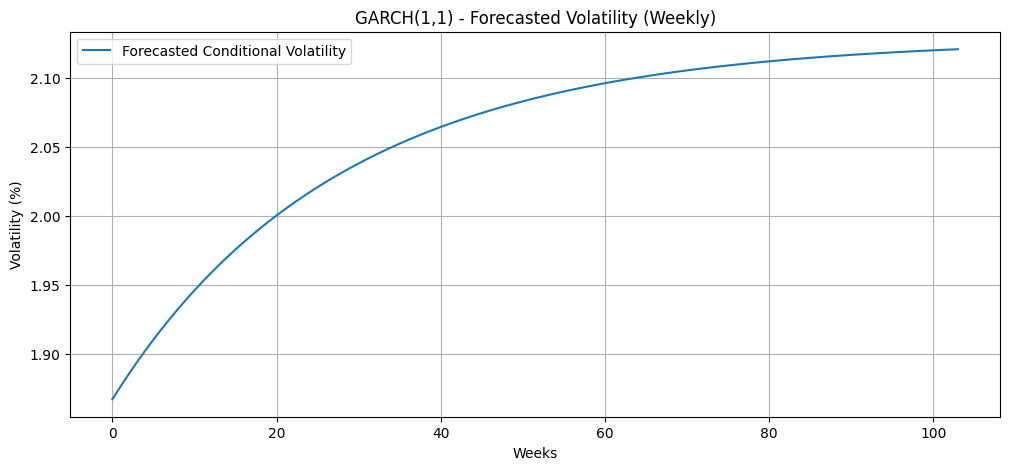

Model       RMSE    MAE    MAPE
----------  ------  -----  ------
ARMA        24.5    18.8   21.22%
Prophet     3.77    2.98   4.26%
ARMA-GARCH  N/A     N/A    N/A


In [42]:
returns = 100 * df['Price'].pct_change().dropna()

# Fit GARCH(1,1) model
from arch import arch_model
garch = arch_model(returns, vol='GARCH', p=1, q=1)
garch_result = garch.fit(disp='off')

print(garch_result.summary())

# Forecasting volatility
forecast_horizon = 104
garch_forecasts = garch_result.forecast(horizon=forecast_horizon)
cond_vol = np.sqrt(garch_forecasts.variance.values[-1, :])

# Plot conditional volatility forecast
plt.figure(figsize=(12,5))
plt.plot(cond_vol, label="Forecasted Conditional Volatility")
plt.title("GARCH(1,1) - Forecasted Volatility (Weekly)")
plt.xlabel("Weeks")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid(True)
plt.show()


# Comparing GARCH volatility-adjusted predictions is tricky as it's not directly price forecasting
# but we can still log metrics to show model performance on volatility prediction
from tabulate import tabulate

# Placeholder for table comparison: Assume you've computed other metrics previously
comparison_table = [
    ["Model", "RMSE", "MAE", "MAPE"],
    ["ARMA", 24.50, 18.80, "21.22%"],
    ["Prophet", 3.77, 2.98, "4.26%"],
    ["ARMA-GARCH", "N/A", "N/A", "N/A"]
]

print(tabulate(comparison_table, headers="firstrow"))